In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from math import sqrt
import qriemannopt as qro

### Many qubits IC POVM

In [85]:
def kron(A, B):
    """Kronecker product of two tensors
    Args:
        A: tf tensor of shape (q, n, k)
        B: tf tensor of shape (p, m, l)
    Returns:
        tf tensor of shape (q * p, n * m, k * l)"""
    AB = tf.tensordot(A, B, axes=0)
    AB = tf.transpose(AB, (0, 3, 1, 4, 2, 5))
    shape = AB.shape
    AB = tf.reshape(AB, (shape[0] * shape[1],
                         shape[2] * shape[3],
                         shape[4] * shape[5]))
    return AB

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# coordinates of thetrahedron peaks
s0 = tf.constant([0, 0, 1], dtype=tf.complex128)
s1 = tf.constant([2 * sqrt(2) / 3, 0, -1/3], dtype=tf.complex128)
s2 = tf.constant([-sqrt(2) / 3, sqrt(2 / 3), -1 / 3], dtype=tf.complex128)
s3 = tf.constant([-sqrt(2) / 3, -sqrt(2 / 3), -1 / 3], dtype=tf.complex128)

# coordinates of thetrahedron peaks in one tensor
s = tf.concat([s0[tf.newaxis],
               s1[tf.newaxis],
               s2[tf.newaxis],
               s3[tf.newaxis]], axis=0)

# One qubit thetrahedral POVM
M = 0.25 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(s, sigma, axes=1))

# Many qubits POVM
num_of_qubits = 3  # number of qubits
Mmq = M
for _ in range(num_of_qubits - 1):
    Mmq = kron(Mmq, M)

### Data set generation (measurements outcomes simulation)

In [86]:
num_of_meas = 100000  # number of measurements

# Random density matrix
rho = tf.random.normal((2 ** num_of_qubits, 2 ** num_of_qubits, 2), dtype=tf.float64)
rho = qro.manifold.real_to_complex(rho)
rho = tf.linalg.adjoint(rho) @ rho
rho_true = rho / tf.linalg.trace(rho)

# Measurements simulation
P = tf.cast(tf.einsum('ijk,kj->i', Mmq, rho), dtype=tf.float64)
eps = tf.random.uniform((num_of_meas,
                         2 ** (2 * num_of_qubits)),
                        dtype=tf.float64)
eps = -tf.math.log(-tf.math.log(eps))
ind_set = tf.math.argmax(eps + tf.math.log(P), axis=-1)
M_set = tf.gather_nd(Mmq, ind_set[:, tf.newaxis])

### Learning

In [87]:
# Random density matrix (Variable)
rho = tf.random.normal((2 ** num_of_qubits, 2 ** num_of_qubits, 2), dtype=tf.float64)
rho = qro.manifold.real_to_complex(rho)
rho = tf.linalg.adjoint(rho) @ rho
rho = rho / tf.linalg.trace(rho)
rho_var = tf.Variable(qro.manifold.complex_to_real(rho))

m = qro.manifold.DensM()
opt = qro.optimizers.RAdam(m, 0.3)
dist = []
losses = []
for _ in range(2000):
    with tf.GradientTape() as tape:
        rho_var_c = qro.manifold.real_to_complex(rho_var)
        rho_var_c = rho_var_c / tf.linalg.trace(rho_var_c)
        p = tf.cast(tf.tensordot(tf.reshape(M_set, (num_of_meas, -1)),
                                 tf.reshape(tf.transpose(rho_var_c), (-1,)), axes=1), dtype=tf.float64)
        loss = -tf.reduce_mean(tf.math.log(p))
        losses.append(loss)
    grad = tape.gradient(loss, rho_var)
    opt.apply_gradients(zip([grad], [rho_var]))
    dist.append(0.5 * tf.reduce_sum(tf.abs(tf.linalg.eigvalsh(rho_var_c - rho_true))))

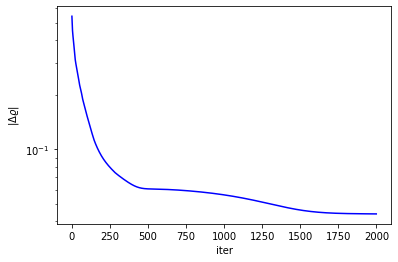

In [98]:
plt.plot(dist, 'b')
plt.yscale('log')
plt.ylabel(r'$|\Delta\varrho|$')
plt.xlabel('iter')
plt.savefig('trace_dist.pdf')

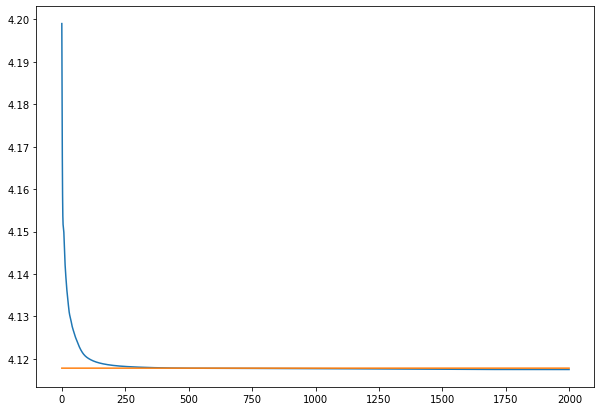

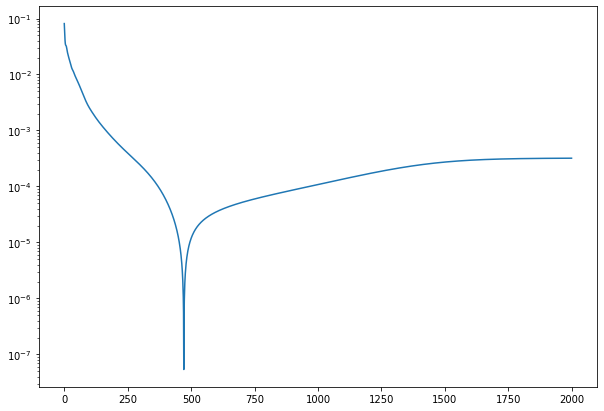

In [89]:
true_llh = -tf.reduce_mean(tf.math.log(tf.cast(tf.linalg.trace(rho_true @ M_set),
                                               dtype=tf.float64)))
true_llh = true_llh * tf.ones(len(losses), dtype=tf.float64)
losses = tf.convert_to_tensor(losses)
fig = plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.plot(true_llh)
fig = plt.figure(figsize=(10, 7))
plt.plot(tf.abs(losses - true_llh))
plt.yscale('log')